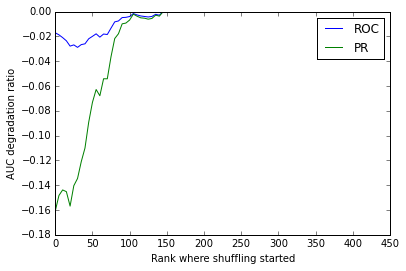

In [11]:
%matplotlib inline
from sklearn import datasets, linear_model, metrics
import matplotlib.pyplot as plt
import numpy as np

def predict_boston_data(class_threshold=30):
    boston_data = datasets.load_boston()
    x_train = boston_data.data
    y_true = boston_data.target >= class_threshold # fi class_threshold==40: Positive: 31/ Negative: 475

    logreg = linear_model.LogisticRegression(penalty='l1',C=1.0)
    logreg.fit(x_train,y_true)
    y_predict = logreg.predict_proba(x_train)[:,1] # predict learned data itself

    return y_true,y_predict

def print_roc(y_true,y_predict):
    (fpr, tpr, _)= metrics.roc_curve(y_true,y_predict)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    auc = metrics.auc(fpr,tpr)
    print('roc_auc',auc)
    return auc

def print_precision_recall(y_true,y_predict):
    (precision, recall, _)= metrics.precision_recall_curve(y_true,y_predict)
    plt.plot(recall,precision)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()
    auc = metrics.auc(recall,precision)
    print('pr_auc',auc)
    return auc

# def calc_auc_directly(y_true,y_predict,curve_function):
#     (x1,x2,_) = curve_function(y_true,y_predict)
#     return metrics.auc(x1,x2)

def calc_roc_auc(y_true,y_predict):
     (x1,x2,_) = metrics.roc_curve(y_true,y_predict)
     return metrics.auc(x1,x2)

def calc_pr_auc(y_true,y_predict):
     (x1,x2,_) = metrics.precision_recall_curve(y_true,y_predict)
     return metrics.auc(x2,x1)

def shuffle_array_partially(y_predict,fr,to):
    y_predict_shuffled = np.copy(y_predict)
    np.random.shuffle(y_predict_shuffled[fr:to])
    return y_predict_shuffled

def generate_frto(array_length,ran=30,skip=5):
    fr=0
    to=ran
    frto_list = []
    while 1:
        to_not_exceeds_array_length = to < array_length
        if to_not_exceeds_array_length:
            frto_list.append( (fr,to) )
        else:
            frto_list.append( (fr,array_length) )
            break
        fr = fr+skip
        to = fr+ran
    return frto_list

if __name__ == '__main__':
    trial = 10
    y_true,y_predict = predict_boston_data(30)
    sort_indices = np.argsort(y_predict)[::-1]
    y_true=y_true[sort_indices]
    y_predict=y_predict[sort_indices]
    default_roc_auc = calc_roc_auc(y_true,y_predict)
    default_pr_auc = calc_pr_auc(y_true,y_predict)

    target_indices = generate_frto(len(y_predict),ran=100,skip=5)
    degrad_ratio_roc = []
    degrad_ratio_pr = []
    for i,(fr,to) in enumerate(target_indices):
        rocs=[]
        prs=[]
        for tr in range(0,trial):
            y_predict_shuffled = shuffle_array_partially(y_predict,fr,to)
            rocs.append((calc_roc_auc(y_true,y_predict_shuffled)-default_roc_auc)/default_roc_auc)
            prs.append((calc_pr_auc(y_true,y_predict_shuffled)-default_pr_auc)/default_pr_auc)
        degrad_ratio_roc.append(sum(rocs)/trial)
        degrad_ratio_pr.append(sum(prs)/trial)

    x = [fr for (fr,to) in target_indices]
    plt.plot(x,degrad_ratio_roc,label='ROC')
    plt.plot(x,degrad_ratio_pr,label='PR')
    plt.xlabel('Rank where shuffling started')
    plt.ylabel('AUC degradation ratio')
    plt.legend(loc="upper right")
    plt.show()
    # for roc_auc, pr_auc in zip(degrad_ratio_roc,degrad_ratio_pr):
    #     print("ROC: {0:.5f}, PR: {1:.5f}".format(roc_auc,pr_auc))

